# Proyek Klasifikasi Gambar: Shoe vs Sandal vs Boot Image Dataset (15K Images)
- **Nama:** Muhammad Rizki
- **Email:** mrizki135790@gmail.com
- **ID Dicoding:** rizki_muhammad

## Load dataset from kaggle

In [1]:
# Setup Kaggle API
!pip install -q kaggle

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!chmod 600 /content/kaggle.json

# Download dataset
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

# Unzip
!unzip -q shoe-vs-sandal-vs-boot-dataset-15k-images.zip -d dataset

!ls dataset


Dataset URL: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
License(s): copyright-authors
'Shoe vs Sandal vs Boot Dataset'


## Import libraries


In [59]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Standard libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Scikit-learn utilities
from sklearn.model_selection import train_test_split

# TensorFlow and Keras core modules
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *

# TensorFlow Keras losses and optimizers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Kernel initializer
from tensorflow.keras.initializers import he_normal

# Keras callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Pretrained models
from tensorflow.keras.applications import ResNet50, Xception

# Image preprocessing and data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

# Keras custom SavedModel loader layer
from keras.layers import TFSMLayer

# colab files
from google.colab import files

## Load data


In [3]:
# Directory containing the "Train" folder
directory = "/content/dataset/Shoe vs Sandal vs Boot Dataset"

# List of categories (subfolder names)
categories = ["Boot", "Sandal","Shoe"]

# Initialize lists to store filenames and categories
filenames = []
category_labels = []

# Iterate through the categories
for category in categories:
    # Path to the current category folder
    category_folder = os.path.join(directory, category)
    # List all filenames in the category folder
    category_filenames = os.listdir(category_folder)
    # Append filenames and corresponding category labels
    filenames.extend(category_filenames)
    category_labels.extend([category] * len(category_filenames))

# Create DataFrame
df = pd.DataFrame({
    'filename': filenames,
    'category': category_labels
})

In [4]:
# convert the filenames and class names to NumPy arrays
filenames = np.array(filenames)
labels = np.array(category_labels)

## Data Checking

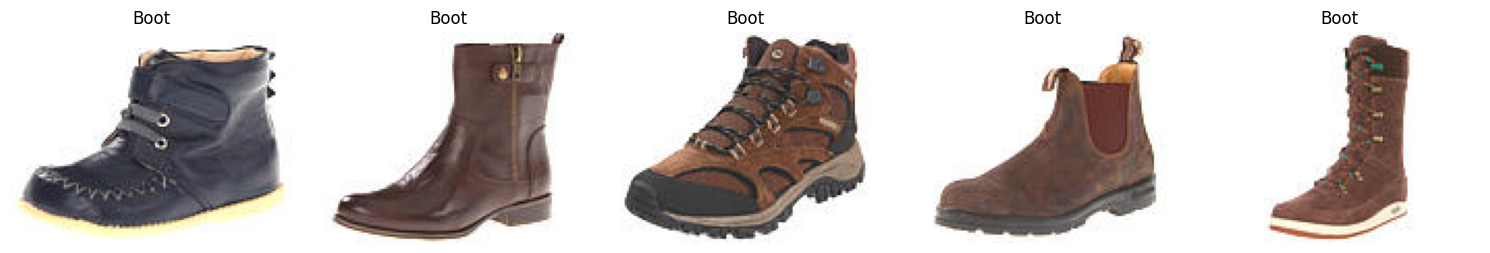

In [5]:
# Display a few sample images
num_samples = 5  # Number of samples to display
plt.figure(figsize=(15, 5))

for i in range(num_samples):
  image_path = os.path.join(directory, df['category'][i], df['filename'][i])
  try:
    img = mpimg.imread(image_path)
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(df['category'][i])
    plt.axis('off')
  except FileNotFoundError:
    print(f"Image not found: {image_path}")

plt.tight_layout()
plt.show()


## Non-uniform resolution dataset

In [6]:
import cv2

def check_resolution_uniformity(directory, categories):
    """
    Checks if images within specified subdirectories have uniform resolutions.

    Args:
        directory: The root directory containing the subdirectories.
        categories: A list of subdirectory names (categories).

    Returns:
        True if all images have the same resolution, False otherwise.
        Also prints details about resolution variations.
    """

    first_image_resolution = None
    uniform_resolution = True

    for category in categories:
        category_folder = os.path.join(directory, category)
        for filename in os.listdir(category_folder):
            image_path = os.path.join(category_folder, filename)
            try:
                img = cv2.imread(image_path)
                if img is None:
                    print(f"Error reading image: {image_path}")  # Handle potential errors
                    continue

                resolution = (img.shape[1], img.shape[0])  # (width, height)
                if first_image_resolution is None:
                    first_image_resolution = resolution
                elif resolution != first_image_resolution:
                    uniform_resolution = False
                    print(f"Resolution mismatch: {image_path} has {resolution}, expected {first_image_resolution}")
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    if uniform_resolution:
        print(f"All images have uniform resolution: {first_image_resolution}")
    return uniform_resolution


# Example usage (assuming your directory and categories are defined as in your original code):
uniformity = check_resolution_uniformity(directory, categories)
print(f"Resolution Uniformity: {uniformity}")


Resolution mismatch: /content/dataset/Shoe vs Sandal vs Boot Dataset/Sandal/Sandal (91).jpg has (135, 102), expected (136, 102)
Resolution mismatch: /content/dataset/Shoe vs Sandal vs Boot Dataset/Sandal/Sandal (28).jpg has (135, 102), expected (136, 102)
Resolution Uniformity: False


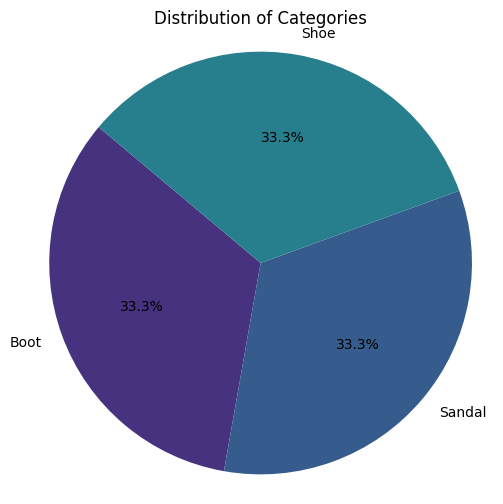

In [13]:
# Count the occurrences of each category in the 'category' column
count = df['category'].value_counts()

# Create a pie chart using Seaborn
plt.figure(figsize=(6, 6) , facecolor='White')
palette = sns.color_palette("viridis")
sns.set_palette(palette)
plt.pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')
plt.axis('equal')

plt.show()  # Show the plot

In [14]:

# Checking dataset distribution
print("Total images:", len(df))
print(df['category'].value_counts())

Total images: 15000
category
Boot      5000
Sandal    5000
Shoe      5000
Name: count, dtype: int64


In [15]:
# Exploring image resolutions
def analyze_image_resolutions(directory, categories):
    """Analyzes the distribution of image resolutions in the dataset"""
    resolutions = {}

    for category in categories:
        category_folder = os.path.join(directory, category)
        for filename in os.listdir(category_folder)[:100]:  # Sample first 100 images per category
            image_path = os.path.join(category_folder, filename)
            try:
                img = cv2.imread(image_path)
                if img is None:
                    continue

                resolution = (img.shape[1], img.shape[0])  # (width, height)
                if resolution in resolutions:
                    resolutions[resolution] += 1
                else:
                    resolutions[resolution] = 1
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    # Sort by frequency
    sorted_resolutions = sorted(resolutions.items(), key=lambda x: x[1], reverse=True)
    print("Most common resolutions:")
    for res, count in sorted_resolutions[:5]:
        print(f"Resolution {res}: {count} images")

    return sorted_resolutions[0][0]  # Return most common resolution

# Find the most common resolution
common_resolution = analyze_image_resolutions(directory, categories)
target_size = common_resolution  # Use the most common resolution

print(f"Target resolution for model: {target_size}")

Most common resolutions:
Resolution (136, 102): 300 images
Target resolution for model: (136, 102)


## Data Splitting

In [16]:
# Define image size and batch size
IMG_WIDTH, IMG_HEIGHT = target_size
BATCH_SIZE = 32

# Create ImageDataGenerator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Create ImageDataGenerator without augmentation for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Split data into training and temporary set (which will be split into validation and test)
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['category'])

# Split temporary set into validation and test sets
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['category'])

print(f"Training samples: {len(df_train)}")
print(f"Validation samples: {len(df_val)}")
print(f"Testing samples: {len(df_test)}")

# Create temporary directories for the DataGenerator
os.makedirs('temp_dataset/train', exist_ok=True)
os.makedirs('temp_dataset/val', exist_ok=True)
os.makedirs('temp_dataset/test', exist_ok=True)

for category in categories:
    os.makedirs(f'temp_dataset/train/{category}', exist_ok=True)
    os.makedirs(f'temp_dataset/val/{category}', exist_ok=True)
    os.makedirs(f'temp_dataset/test/{category}', exist_ok=True)

# Function to copy images to temp directories
def copy_images(df_subset, subset_name):
    for idx, row in df_subset.iterrows():
        src_path = os.path.join(directory, row['category'], row['filename'])
        dst_path = os.path.join(f'temp_dataset/{subset_name}', row['category'], row['filename'])
        try:
            img = cv2.imread(src_path)
            # Resize to common resolution to ensure uniformity
            img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            cv2.imwrite(dst_path, img_resized)
        except Exception as e:
            print(f"Error processing {src_path}: {e}")

# Copy images to temp directories
copy_images(df_train, 'train')
copy_images(df_val, 'val')
copy_images(df_test, 'test')

# Create data generators
train_generator = train_datagen.flow_from_directory(
    'temp_dataset/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    'temp_dataset/val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'temp_dataset/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Training samples: 10500
Validation samples: 2250
Testing samples: 2250
Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.


## Modeling

In [17]:
# Build the CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_initializer=he_normal()),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=he_normal()),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=he_normal()),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=he_normal()),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=he_normal()),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=he_normal()),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Flatten and Dense layers
        Flatten(),
        Dense(256, activation='relu', kernel_initializer=he_normal()),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create the model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)  # Height, Width, Channels
num_classes = len(categories)
model = build_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 102, 136, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 102, 136, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 102, 136, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 102, 136, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 51, 68, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 51, 68, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 68, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 51, 68, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 51, 68, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 51, 68, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 26112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,684,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,975,523 (26.61 MB)

 Trainable params: 6,974,115 (26.60 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [18]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint callback to save best model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# TensorBoard callback for visualization
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True
)

# Define callbacks
callbacks = [early_stopping, model_checkpoint, reduce_lr, tensorboard]

In [19]:
# Train the model
EPOCHS = 35
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks
)

Epoch 1/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6081 - loss: 1.0118
Epoch 1: val_accuracy improved from -inf to 0.34933, saving model to best_model.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 82s 189ms/step - accuracy: 0.6083 - loss: 1.0112 - val_accuracy: 0.3493 - val_loss: 3.3651 - learning_rate: 0.0010
Epoch 2/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7373 - loss: 0.6016
Epoch 2: val_accuracy improved from 0.34933 to 0.41956, saving model to best_model.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 52s 157ms/step - accuracy: 0.7374 - loss: 0.6015 - val_accuracy: 0.4196 - val_loss: 2.8279 - learning_rate: 0.0010
Epoch 3/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8044 - loss: 0.4812
Epoch 3: val_accuracy did not improve from 0.41956
329/329 ━━━━━━━━━━━━━━━━━━━━ 81s 154ms/step - accuracy: 0.8044 - loss: 0.4812 - val_accuracy: 0.3524 - val_loss: 4.1183 - learning_rate: 0.0010
Epoch 4/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8203 - loss: 0.4265
Epoch 4: val_accuracy did not improve from 0.41956
329/329 ━━━━━━━━━━━━━━━━━━━━ 59s 178ms/step - accuracy: 0.8203 - loss: 0.4264 - val_accuracy: 0.3449 - val_loss: 8.6081 - learning_rate: 0.0010
Epoch 5/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8595 - loss: 0.3537
Epoch 5: val_accuracy improved from 0.41956 to 0.42178, saving model to best_model.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 74s 155ms/step - accuracy: 0.8595 - loss: 0.3537 - val_accuracy: 0.4218 - val_loss: 37.7131 - learning_rate: 0.0010
Epoch 6/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8743 - loss: 0.3205
Epoch 6: val_accuracy improved from 0.42178 to 0.85200, saving model to best_model.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 49s 150ms/step - accuracy: 0.8744 - loss: 0.3205 - val_accuracy: 0.8520 - val_loss: 0.3910 - learning_rate: 0.0010
Epoch 7/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8947 - loss: 0.2755
Epoch 7: val_accuracy improved from 0.85200 to 0.87511, saving model to best_model.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 52s 159ms/step - accuracy: 0.8947 - loss: 0.2755 - val_accuracy: 0.8751 - val_loss: 0.3998 - learning_rate: 0.0010
Epoch 8/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9083 - loss: 0.2509
Epoch 8: val_accuracy did not improve from 0.87511
329/329 ━━━━━━━━━━━━━━━━━━━━ 78s 148ms/step - accuracy: 0.9083 - loss: 0.2509 - val_accuracy: 0.6818 - val_loss: 1.0994 - learning_rate: 0.0010
Epoch 9/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9107 - loss: 0.2414
Epoch 9: val_accuracy did not improve from 0.87511
329/329 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - accuracy: 0.9107 - loss: 0.2414 - val_accuracy: 0.8084 - val_loss: 0.5664 - learning_rate: 0.0010
Epoch 10/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9115 - loss: 0.2448
Epoch 10: val_accuracy did not improve from 0.87511
329/329 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - accuracy: 0.9115 - loss: 0.2447 - val_accuracy: 0.8502 - val_loss: 0.5267 - learning_rate: 0.0010
Epoch

329/329 ━━━━━━━━━━━━━━━━━━━━ 79s 150ms/step - accuracy: 0.9402 - loss: 0.1741 - val_accuracy: 0.9569 - val_loss: 0.1204 - learning_rate: 2.0000e-04
Epoch 13/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9390 - loss: 0.1668
Epoch 13: val_accuracy did not improve from 0.95689
329/329 ━━━━━━━━━━━━━━━━━━━━ 50s 152ms/step - accuracy: 0.9390 - loss: 0.1667 - val_accuracy: 0.8600 - val_loss: 0.3745 - learning_rate: 2.0000e-04
Epoch 14/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9473 - loss: 0.1464
Epoch 14: val_accuracy improved from 0.95689 to 0.96267, saving model to best_model.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 51s 154ms/step - accuracy: 0.9473 - loss: 0.1464 - val_accuracy: 0.9627 - val_loss: 0.1192 - learning_rate: 2.0000e-04
Epoch 15/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9499 - loss: 0.1427
Epoch 15: val_accuracy did not improve from 0.96267
329/329 ━━━━━━━━━━━━━━━━━━━━ 80s 148ms/step - accuracy: 0.9499 - loss: 0.1427 - val_accuracy: 0.7898 - val_loss: 0.7975 - learning_rate: 2.0000e-04
Epoch 16/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9515 - loss: 0.1320
Epoch 16: val_accuracy did not improve from 0.96267
329/329 ━━━━━━━━━━━━━━━━━━━━ 83s 152ms/step - accuracy: 0.9514 - loss: 0.1321 - val_accuracy: 0.9391 - val_loss: 0.1885 - learning_rate: 2.0000e-04
Epoch 17/35
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9536 - loss: 0.1375
Epoch 17: val_accuracy did not improve from 0.96267
329/329 ━━━━━━━━━━━━━━━━━━━━ 49s 149ms/step - accuracy: 0.9536 - loss: 0.1374 - val_accuracy: 0.5782 - val_loss: 1.8678 - learning_ra

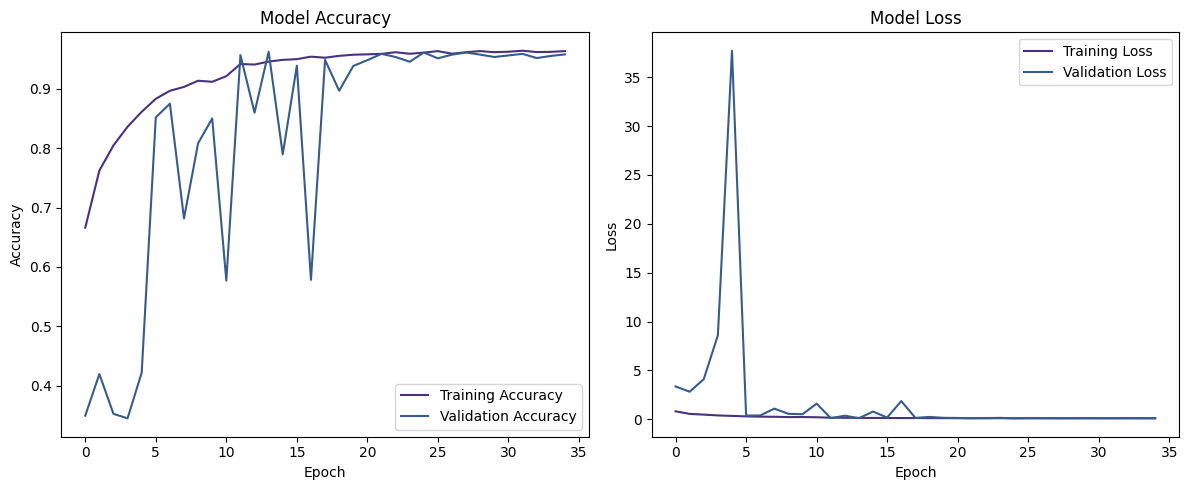

In [20]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluate Model

In [21]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9880 - loss: 0.0334
Test accuracy: 0.9684
Test loss: 0.0900


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


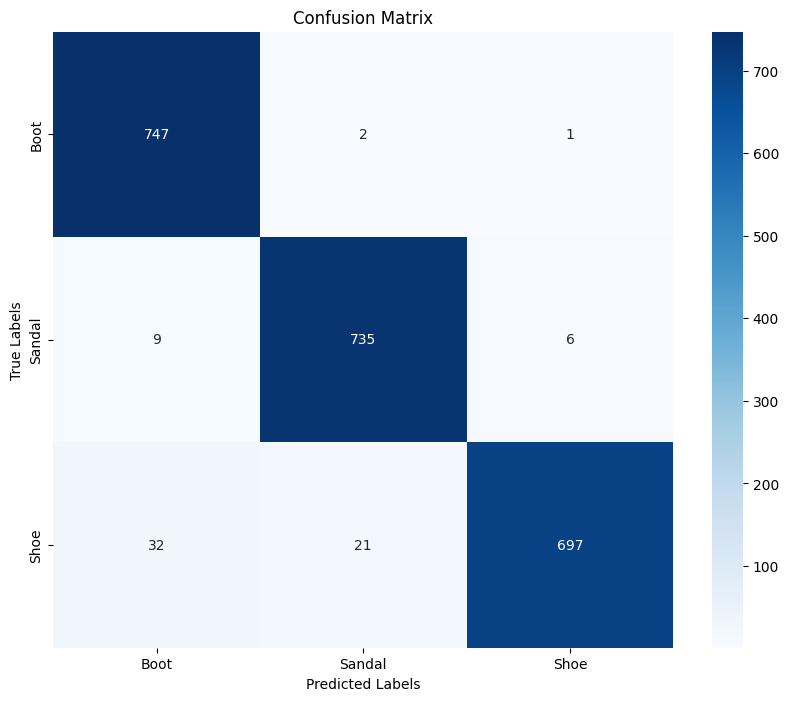

In [36]:
# Confusion matrix
# Get predictions
test_steps = len(test_generator)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
cm = tf.math.confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


## Save model

In [37]:
# Create necessary directories
!mkdir -p saved_model
!mkdir -p tflite
!mkdir -p tfjs_model

In [45]:
# Save model in SavedModel format
model.export('/content/saved_model')

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 102, 136, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135968364017232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135965547219856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135965547220432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135965547218896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135968364015888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135968364017040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135965547221392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135965547221584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135965547222352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135965547220624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1359655472

In [39]:
# Convert and save model in TF-Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

In [40]:
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [31]:
# Save labels for TF-Lite
with open('tflite/label.txt', 'w') as f:
    for category in categories:
        f.write(f"{category}\n")

print("Model saved in TF-Lite format at tflite/")


Model saved in TF-Lite format at tflite/


In [33]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [44]:
# Save model in .h5 format
model.save('model.h5')

# Convert to TensorFlow.js format (run as shell command)
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model


2025-05-09 00:46:44.955872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746751605.055924   18006 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746751605.093924   18006 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


## inference


Testing image: temp_dataset/test/Boot/boot (2127).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


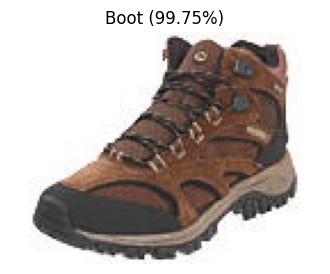

Predicted class: Boot
Confidence: 99.75%
True class: Boot

Testing image: temp_dataset/test/Boot/boot (2047).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


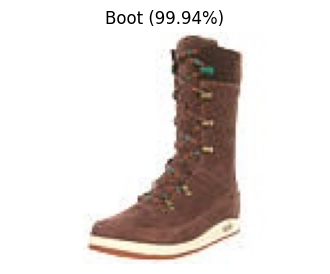

Predicted class: Boot
Confidence: 99.94%
True class: Boot

Testing image: temp_dataset/test/Boot/boot (1714).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


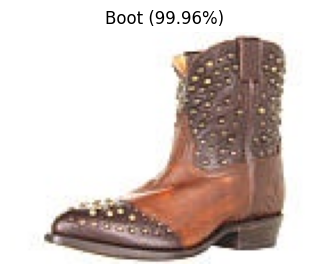

Predicted class: Boot
Confidence: 99.96%
True class: Boot

Testing image: temp_dataset/test/Sandal/Sandal (4329).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


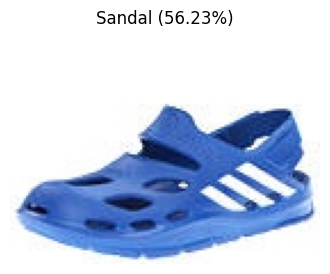

Predicted class: Sandal
Confidence: 56.23%
True class: Sandal

Testing image: temp_dataset/test/Sandal/Sandal (939).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


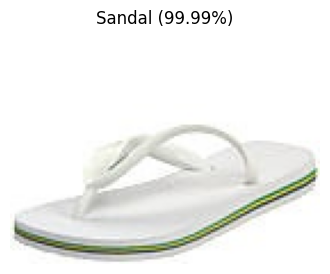

Predicted class: Sandal
Confidence: 99.99%
True class: Sandal

Testing image: temp_dataset/test/Sandal/Sandal (3820).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


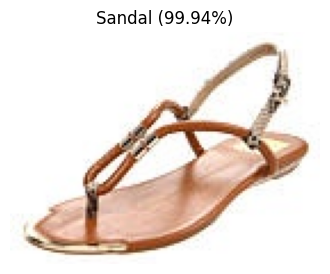

Predicted class: Sandal
Confidence: 99.94%
True class: Sandal

Testing image: temp_dataset/test/Shoe/Shoe (1513).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


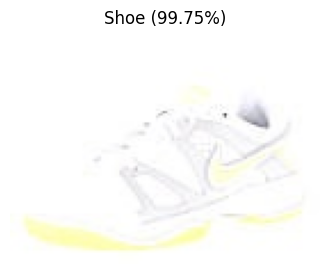

Predicted class: Shoe
Confidence: 99.75%
True class: Shoe

Testing image: temp_dataset/test/Shoe/Shoe (4636).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


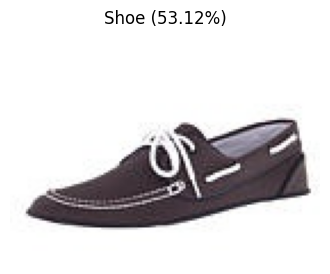

Predicted class: Shoe
Confidence: 53.12%
True class: Shoe

Testing image: temp_dataset/test/Shoe/Shoe (923).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


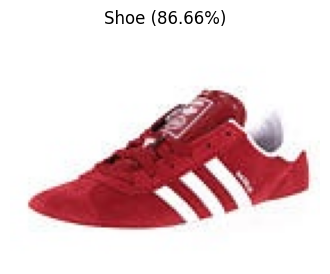

Predicted class: Shoe
Confidence: 86.66%
True class: Shoe


In [58]:
def load_and_preprocess_image(image_path, target_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Load model menggunakan TFSMLayer
layer = TFSMLayer("saved_model", call_endpoint="serving_default")
loaded_model = Sequential([layer])

# Loop untuk masing-masing kategori
for category in categories:
    image_dir = os.path.join('temp_dataset/test', category)
    image_files = os.listdir(image_dir)[:3]  # Ambil sejumlah gambar

    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        print(f"\nTesting image: {image_path}")

        preprocessed_img = load_and_preprocess_image(image_path, (IMG_WIDTH, IMG_HEIGHT))
        prediction_dict = loaded_model.predict(preprocessed_img)
        output_key = list(prediction_dict.keys())[0]
        prediction = prediction_dict[output_key]

        predicted_class = categories[np.argmax(prediction)]
        confidence = np.max(prediction) * 100

        # Tampilkan gambar dan hasil prediksi
        plt.figure(figsize=(4, 4))
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"{predicted_class} ({confidence:.2f}%)")
        plt.axis('off')
        plt.show()

        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")
        print(f"True class: {category}")

In [62]:
# Compress the model folders into a single ZIP file for download
!zip -r /content/model_download.zip /content/saved_model /content/tfjs_model /content/tflite

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/variables/variables.index (deflated 73%)
  adding: content/saved_model/saved_model.pb (deflated 89%)
  adding: content/saved_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard5of7.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard7of7.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard1of7.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard6of7.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard4of7.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard2of7.bin (deflated 7%)
  adding: content/tfjs_model/model.json (deflated 92%)
  adding: content/tfjs_model/group1-shard3of7.bin (deflated 7%)
  adding: content/tflite/ (stored 0%)

In [63]:
files.download('/content/model_download.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Please give me 5 stars, thank you🙏😊
